In [3]:
# Install once in this kernel
!pip install -U pip
!pip install tensorflow==2.15.0 numpy pandas matplotlib

import tensorflow as tf, sys, platform
print("Python:", sys.executable, platform.python_version())
print("TensorFlow:", tf.__version__)
from tensorflow.keras import layers, models


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Python: D:\Anaconda3\envs\fedci\python.exe 3.10.18
TensorFlow: 2.15.0


ERROR: Could not find a version that satisfies the requirement tensorflow==2.15.0 (from versions: 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.15.0


In [8]:
import os, glob, json, time, math, sys, platform
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models

# Reproducibility
np.random.seed(7)
tf.random.set_seed(7)

print("Python:", sys.executable, platform.python_version())
print("TensorFlow:", tf.__version__)
assert tuple(map(int, tf.__version__.split('.')[:2])) >= (2, 15), "Use TF 2.15+ in the fedci kernel."


Python: D:\Anaconda3\envs\fedci\python.exe 3.10.18
TensorFlow: 2.15.0


In [11]:
# CHANGE THIS to the folder that contains files like 100_ekg.csv, 100_annotations_1.csv, etc.
DATA_DIR = r"D:\hippo file transfer\Amrita\AMRITA\AMRITA 1st Year\CI\archive"

if not os.path.isdir(DATA_DIR):
    raise FileNotFoundError(f"DATA_DIR not found: {DATA_DIR}")

# quick peek
files = sorted([f for f in os.listdir(DATA_DIR) if f.endswith(("_ekg.csv","_ekg.json","_annotations_1.csv","_annotations_1.json"))])[:12]
files


['100_annotations_1.csv',
 '100_annotations_1.json',
 '100_ekg.csv',
 '100_ekg.json',
 '101_annotations_1.csv',
 '101_annotations_1.json',
 '101_ekg.csv',
 '101_ekg.json',
 '102_annotations_1.csv',
 '102_annotations_1.json',
 '102_ekg.csv',
 '102_ekg.json']

In [12]:
SYMBOL_MAP_PATH = os.path.join(DATA_DIR, "annotation_symbols.csv")

# Default mapping; will be overridden if your CSV has aami_class.
AAMI_MAP = {
    'N':'N','L':'N','R':'N','e':'N','j':'N',    # Normal
    'S':'S','A':'S','a':'S','J':'S',            # Supraventricular
    'V':'V','E':'V',                            # Ventricular
    'F':'F',                                    # Fusion
    '/':'Q','Q':'Q','?':'Q'                     # Unknown / paced / etc.
}
# Non-beat / rhythm markers we skip when cutting beats
NON_BEAT = set(['+', '~', '|', '"', '!', '[', ']', 'p', 't', 'u', 'B', 'x'])

if os.path.exists(SYMBOL_MAP_PATH):
    dfm = pd.read_csv(SYMBOL_MAP_PATH)
    if {"symbol","aami_class"}.issubset(dfm.columns):
        for _, r in dfm.iterrows():
            s = str(r["symbol"]).strip()
            c = (str(r["aami_class"]).strip().upper()
                 if pd.notna(r["aami_class"]) else None)
            if c in {'N','S','V','F','Q'}:
                AAMI_MAP[s] = c

AAMI_MAP


{'N': 'N',
 'L': 'N',
 'R': 'N',
 'e': 'N',
 'j': 'N',
 'S': 'S',
 'A': 'S',
 'a': 'S',
 'J': 'S',
 'V': 'V',
 'E': 'V',
 'F': 'F',
 '/': 'Q',
 'Q': 'Q',
 '?': 'Q'}

In [13]:
def choose_lead(df: pd.DataFrame) -> str:
    # Prefer common leads if present
    for c in ['MLII','ML2','II','V5']:
        if c in df.columns and pd.api.types.is_numeric_dtype(df[c]):
            return c
    # Fallback: first numeric column
    for c in df.columns:
        if pd.api.types.is_numeric_dtype(df[c]):
            return c
    raise ValueError("No numeric signal column found in EKG file.")

def read_record_pair(rec_id: str, base: str):
    ekg_csv = os.path.join(base, f"{rec_id}_ekg.csv")
    ann_csv = os.path.join(base, f"{rec_id}_annotations_1.csv")
    ekg_json = os.path.join(base, f"{rec_id}_ekg.json")
    ann_json = os.path.join(base, f"{rec_id}_annotations_1.json")

    # --- signal
    if os.path.exists(ekg_csv):
        df_sig = pd.read_csv(ekg_csv)
    elif os.path.exists(ekg_json):
        data = json.load(open(ekg_json))
        df_sig = pd.DataFrame(data)
    else:
        return None

    lead = choose_lead(df_sig)
    sig = df_sig[lead].astype('float32').values

    # --- annotations
    pairs = None
    if os.path.exists(ann_csv):
        df_ann = pd.read_csv(ann_csv)
        # pick columns robustly
        idx_candidates = [c for c in df_ann.columns if c.lower() in ('index','sample','pos','r')]
        sym_candidates = [c for c in df_ann.columns if ('symbol' in c.lower()) or ('label' in c.lower()) or (c.lower()=='type')]
        if not idx_candidates or not sym_candidates:
            return None
        idx_col, sym_col = idx_candidates[0], sym_candidates[0]
        pairs = list(zip(df_ann[idx_col].astype(int).tolist(), df_ann[sym_col].astype(str).tolist()))
    elif os.path.exists(ann_json):
        data = json.load(open(ann_json))
        if isinstance(data, list):
            pairs = [(int(x.get('index', x.get('sample'))), str(x.get('symbol', x.get('label')))) for x in data]
        else:
            idxs = [int(i) for i in data.get('index', data.get('sample', []))]
            syms = [str(s) for s in data.get('symbol', data.get('label', []))]
            pairs = list(zip(idxs, syms))
    else:
        return None

    return sig, pairs, lead

def cut_beats(signal: np.ndarray, ann_pairs, fs=360, win_sec=0.6):
    """
    Centered window on each annotated R index. 0.6 s @ 360 Hz => 216 samples (108 on each side).
    """
    half = int(fs * win_sec / 2)
    X, y = [], []
    for idx, sym in ann_pairs:
        if sym in NON_BEAT:
            continue
        label = AAMI_MAP.get(sym, 'Q')
        s, e = idx - half, idx + half
        if s < 0 or e > len(signal):
            continue
        X.append(signal[s:e])
        y.append(label)
    return np.asarray(X, dtype='float32'), np.asarray(y)

# collect record IDs
rec_ids = sorted({f.split('_')[0] for f in os.listdir(DATA_DIR)
                  if f.endswith(('_ekg.csv','_ekg.json'))})
if not rec_ids:
    raise RuntimeError("No *_ekg files found in DATA_DIR.")

# build
FS, WIN = 360, 0.6
X_list, y_list, rid_list, per_rec = [], [], [], {}
t0 = time.time()
for k, rid in enumerate(rec_ids, 1):
    out = read_record_pair(rid, DATA_DIR)
    if out is None:
        continue
    sig, pairs, lead = out
    Xr, yr = cut_beats(sig, pairs, fs=FS, win_sec=WIN)
    if len(Xr) == 0:
        continue
    X_list.append(Xr)
    y_list.append(yr)
    rid_list.append(np.array([rid]*len(yr)))
    per_rec[rid] = {
        "lead": lead,
        "n_beats": int(len(yr)),
        "counts": {c:int((yr==c).sum()) for c in np.unique(yr)}
    }
    if k % 10 == 0:
        print(f"Processed {k}/{len(rec_ids)} records...")

X = np.concatenate(X_list, axis=0)
y = np.concatenate(y_list, axis=0)
rid_arr = np.concatenate(rid_list, axis=0)

print(f"Built beats in {time.time()-t0:.1f}s | X:{X.shape} y:{y.shape}")
print("Class counts:", {c:int((y==c).sum()) for c in np.unique(y)})


Processed 10/48 records...
Processed 20/48 records...
Processed 30/48 records...
Processed 40/48 records...
Built beats in 7.5s | X:(109462, 216) y:(109462,)
Class counts: {'F': 802, 'N': 90603, 'Q': 8041, 'S': 2781, 'V': 7235}


In [14]:
label_to_int = {'N':0,'S':1,'V':2,'F':3,'Q':4}
y_int = np.array([label_to_int[c] for c in y], dtype=np.int64)

rng = np.random.default_rng(0)
idx_all = np.arange(len(y_int))
train_idx, test_idx = [], []

for cls in sorted(set(y_int.tolist())):
    cls_idx = idx_all[y_int == cls]
    rng.shuffle(cls_idx)
    n = len(cls_idx)
    n_train = int(0.7 * n)
    train_idx += cls_idx[:n_train].tolist()
    test_idx  += cls_idx[n_train:].tolist()

train_idx = np.array(train_idx); test_idx = np.array(test_idx)

X_train = X[train_idx][..., None]
y_train = y_int[train_idx]
rid_train = rid_arr[train_idx]

X_test  = X[test_idx][..., None]
y_test  = y_int[test_idx]

print("Train:", X_train.shape, " Test:", X_test.shape)


Train: (76621, 216, 1)  Test: (32841, 216, 1)


In [15]:
clients = {}
client_ids = np.unique(rid_train)
for cid in client_ids:
    idx = np.where(rid_train == cid)[0]
    # skip tiny clients that may cause instability (< 20 beats)
    if len(idx) < 20:
        continue
    clients[cid] = (X_train[idx], y_train[idx])

print(f"Clients: {len(clients)} ; median beats/client:",
      int(np.median([len(v[1]) for v in clients.values()])))


Clients: 48 ; median beats/client: 1567


In [16]:
#models and helpers
def build_autoencoder(input_len: int) -> tf.keras.Model:
    inp = layers.Input((input_len, 1))
    # Encoder
    x = layers.Conv1D(32, 3, padding='same', activation='relu')(inp)
    x = layers.MaxPool1D(2)(x)
    x = layers.Conv1D(64, 3, padding='same', activation='relu')(x)
    x = layers.MaxPool1D(2)(x)
    x = layers.Conv1D(128, 3, padding='same', activation='relu')(x)
    enc = layers.MaxPool1D(2, name="enc_out")(x)
    # Decoder
    x = layers.UpSampling1D(2)(enc)
    x = layers.Conv1D(64, 3, padding='same', activation='relu')(x)
    x = layers.UpSampling1D(2)(x)
    x = layers.Conv1D(32, 3, padding='same', activation='relu')(x)
    x = layers.UpSampling1D(2)(x)
    out = layers.Conv1D(1, 3, padding='same')(x)
    ae = models.Model(inp, out, name='ae')
    ae.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
    return ae

def extract_encoder(ae: tf.keras.Model) -> tf.keras.Model:
    return models.Model(ae.input, ae.get_layer("enc_out").output, name="encoder")

def build_classifier(encoder: tf.keras.Model, n_classes=5, freeze_encoder=True) -> tf.keras.Model:
    inp = layers.Input(encoder.input_shape[1:])
    x = encoder(inp)
    if freeze_encoder:
        encoder.trainable = False
    x = layers.Conv1D(128, 3, padding='same', activation='relu')(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    out = layers.Dense(n_classes, activation='softmax')(x)
    clf = models.Model(inp, out, name='clf')
    clf.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return clf

def fedavg(weight_sets, sizes):
    total = np.sum(sizes)
    return [sum(ws[i]*sizes[k] for k,ws in enumerate(weight_sets)) / total
            for i in range(len(weight_sets[0]))]

def add_noise(X, pct=0.2, seed=7):
    rng = np.random.default_rng(seed)
    std = X.std(axis=1, keepdims=True) + 1e-8
    return X + rng.normal(0,1,size=X.shape)*std*pct


In [17]:
#Stage A: Federated denoising Autoencoder

INPUT_LEN = X.shape[1]
BATCH = 256
ROUNDS_AE, LOCAL_EPOCHS_AE = 3, 1  # increase later for quality

ae_global = build_autoencoder(INPUT_LEN)

for r in range(ROUNDS_AE):
    w_list, n_list = [], []
    t0 = time.time()
    for cid, (Xi, _) in clients.items():
        ae_local = build_autoencoder(INPUT_LEN)
        ae_local.set_weights(ae_global.get_weights())
        # 10–30% noise per client per round
        Xi_noisy = add_noise(Xi.squeeze(-1), pct=float(np.random.uniform(0.10, 0.30)))[..., None]
        ae_local.fit(Xi_noisy, Xi, epochs=LOCAL_EPOCHS_AE, batch_size=BATCH, verbose=0)
        w_list.append(ae_local.get_weights())
        n_list.append(len(Xi))
    ae_global.set_weights(fedavg(w_list, n_list))
    print(f"[AE] round {r+1}/{ROUNDS_AE} in {time.time()-t0:.1f}s")





[AE] round 1/3 in 70.0s
[AE] round 2/3 in 64.9s
[AE] round 3/3 in 63.4s


In [18]:
#Stage B: Transfer encoder → Federated classifier
encoder = extract_encoder(ae_global) 
clf_global = build_classifier(encoder, n_classes=5, freeze_encoder=True)

ROUNDS_CLF, LOCAL_EPOCHS_CLF = 5, 1  # increase later for accuracy

for r in range(ROUNDS_CLF):
    w_list, n_list = [], []
    t0 = time.time()
    for cid, (Xi, yi) in clients.items():
        clf_local = build_classifier(encoder, n_classes=5, freeze_encoder=True)
        clf_local.set_weights(clf_global.get_weights())
        clf_local.fit(Xi, yi, epochs=LOCAL_EPOCHS_CLF, batch_size=BATCH, verbose=0)
        w_list.append(clf_local.get_weights())
        n_list.append(len(Xi))
    clf_global.set_weights(fedavg(w_list, n_list))

    # light sanity ping on a small slice
    s = min(4096, len(y_train))
    idx = np.random.choice(len(y_train), size=s, replace=False)
    _, acc = clf_global.evaluate(X_train[idx], y_train[idx], verbose=0)
    print(f"[CLF] round {r+1}/{ROUNDS_CLF} | train-sample acc: {acc:.4f} in {time.time()-t0:.1f}s")



[CLF] round 1/5 | train-sample acc: 0.8462 in 35.2s
[CLF] round 2/5 | train-sample acc: 0.8315 in 36.8s
[CLF] round 3/5 | train-sample acc: 0.8247 in 34.1s
[CLF] round 4/5 | train-sample acc: 0.8198 in 36.3s
[CLF] round 5/5 | train-sample acc: 0.8306 in 40.7s


In [19]:
#Final evaluation on the 30% holdout

test_loss, test_acc = clf_global.evaluate(X_test, y_test, verbose=0)
print(f"\nFINAL TEST ACCURACY (30% holdout): {test_acc:.4f}")

def confusion_matrix_np(y_true, y_pred, n=5):
    cm = np.zeros((n,n), dtype=int)
    for t,p in zip(y_true, y_pred):
        cm[int(t), int(p)] += 1
    return cm

y_pred = np.argmax(clf_global.predict(X_test, verbose=0), axis=1)
cm = confusion_matrix_np(y_test, y_pred, n=5)
print(pd.DataFrame(cm, index=['N','S','V','F','Q'], columns=['N','S','V','F','Q']))



FINAL TEST ACCURACY (30% holdout): 0.8277
       N  S  V  F  Q
N  27181  0  0  0  0
S    835  0  0  0  0
V   2171  0  0  0  0
F    241  0  0  0  0
Q   2413  0  0  0  0


In [20]:
#Save artifacts
import os
from tensorflow.keras.models import save_model

# Create artifacts folder
os.makedirs("artifacts", exist_ok=True)

# Save classifier and autoencoder in both formats
clf_global.save("artifacts/fed_classifier_ae_transfer.keras")   # new format
clf_global.save("artifacts/fed_classifier_ae_transfer.h5")      # legacy HDF5

ae_global.save("artifacts/fed_autoencoder.keras")               # new format
ae_global.save("artifacts/fed_autoencoder.h5")                  # legacy HDF5

# Save split indices + label mapping
np.savez(
    "artifacts/split_70_30.npz", 
    train_idx=train_idx,
    test_idx=test_idx,
    label_to_int={'N':0,'S':1,'V':2,'F':3,'Q':4}
)

print("✅ Models and artifacts saved in both .keras and .h5 formats inside ./artifacts")


✅ Models and artifacts saved in both .keras and .h5 formats inside ./artifacts


D:\Anaconda3\envs\fedci\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
import tensorflow as tf

# Load your saved model (use .keras if you followed best practice)
clf_model = tf.keras.models.load_model("artifacts/fed_classifier_ae_transfer.keras")

# Convert to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(clf_model)

# (Optional) enable optimizations to make it even smaller/faster
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

# Save .tflite file
with open("artifacts/fed_classifier_ae_transfer.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Exported to artifacts/fed_classifier_ae_transfer.tflite")


INFO:tensorflow:Assets written to: C:\Users\mhima\AppData\Local\Temp\tmpvhhav0iv\assets


INFO:tensorflow:Assets written to: C:\Users\mhima\AppData\Local\Temp\tmpvhhav0iv\assets


✅ Exported to artifacts/fed_classifier_ae_transfer.tflite


In [22]:
# Load back the TFLite model
interpreter = tf.lite.Interpreter(model_path="artifacts/fed_classifier_ae_transfer.tflite")
interpreter.allocate_tensors()

# Get input & output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input shape expected:", input_details[0]['shape'])
print("Output shape:", output_details[0]['shape'])

# Test on a single beat from your test set
sample = X_test[0:1]  # one ECG beat window
sample = sample.astype('float32')

interpreter.set_tensor(input_details[0]['index'], sample)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

print("Predicted probabilities:", output_data)
print("Predicted class:", output_data.argmax())


Input shape expected: [  1 216   1]
Output shape: [1 5]
Predicted probabilities: [[0.74832445 0.07887257 0.08622146 0.04350133 0.04308016]]
Predicted class: 0


In [25]:
import numpy as np
import pandas as pd

LABELS = ['N','S','V','F','Q']  # 0..4

def predict_pretty_keras(beat_216_list, model):
    """
    beat_216_list: list[float] of length 216 (one ECG beat window).
    model: a compiled Keras model (e.g., clf_global).
    """
    # shape to (1,216,1)
    x = np.array(beat_216_list, dtype='float32').reshape(1, 216, 1)

    # run prediction
    probs = model.predict(x, verbose=0)[0]
    pred_idx = int(np.argmax(probs))
    pred_label = LABELS[pred_idx]

    # make a nice table (sorted by probability)
    df = pd.DataFrame({
        "Class": LABELS,
        "Probability": probs
    }).sort_values("Probability", ascending=False).reset_index(drop=True)
    df["Probability"] = (df["Probability"]*100).round(2).astype(str)+" %"

    print(" Predicted class:", pred_label)
    display(df)

# ----------- EXAMPLE USAGE ------------
# 1) Paste your beat here (216 floats). Below is just a dummy placeholder:
manual_beat = [0.0]*216

# 2) Call with your trained model (clf_global should already be in memory)
predict_pretty_keras(manual_beat, clf_global)


 Predicted class: N


,Class,Probability
0,N,43.22 %
1,V,18.52 %
2,S,14.93 %
3,Q,12.13 %
4,F,11.2 %


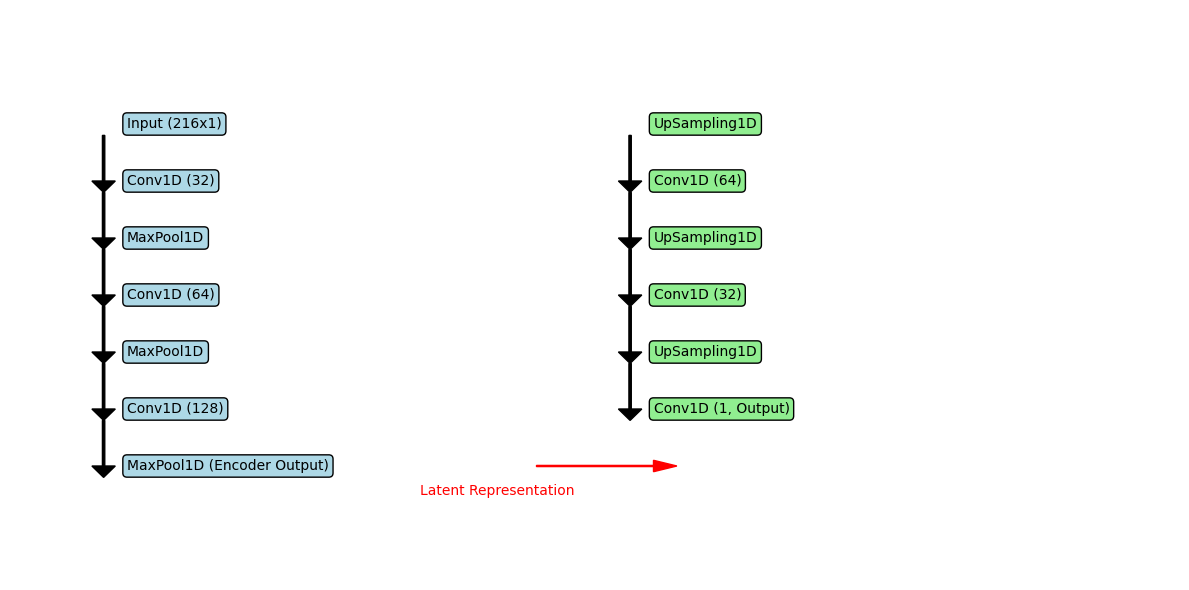

In [26]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrow

# Create figure
fig, ax = plt.subplots(figsize=(12,6))
ax.axis("off")

# Encoder layers
encoder_layers = ["Input (216x1)", "Conv1D (32)", "MaxPool1D", 
                  "Conv1D (64)", "MaxPool1D", 
                  "Conv1D (128)", "MaxPool1D (Encoder Output)"]

# Decoder layers
decoder_layers = ["UpSampling1D", "Conv1D (64)", 
                  "UpSampling1D", "Conv1D (32)", 
                  "UpSampling1D", "Conv1D (1, Output)"]

# Position encoder
x_enc = 0.1
y = 0.8
dy = -0.1

for i, layer in enumerate(encoder_layers):
    ax.text(x_enc, y + dy*i, layer, fontsize=10, ha="left", va="center",
            bbox=dict(boxstyle="round,pad=0.3", fc="lightblue", ec="black"))
    if i > 0:
        ax.add_patch(FancyArrow(x_enc-0.02, y+dy*(i-1)-0.02, 0, dy+0.02, 
                                width=0.002, head_width=0.02, head_length=0.02, color="black"))

# Position decoder
x_dec = 0.55
for i, layer in enumerate(decoder_layers):
    ax.text(x_dec, y + dy*i, layer, fontsize=10, ha="left", va="center",
            bbox=dict(boxstyle="round,pad=0.3", fc="lightgreen", ec="black"))
    if i > 0:
        ax.add_patch(FancyArrow(x_dec-0.02, y+dy*(i-1)-0.02, 0, dy+0.02, 
                                width=0.002, head_width=0.02, head_length=0.02, color="black"))

# Connection between encoder and decoder
ax.add_patch(FancyArrow(0.45, y+dy*(len(encoder_layers)-1), 0.1, 0, 
                        width=0.002, head_width=0.02, head_length=0.02, color="red"))
ax.text(0.35, y+dy*(len(encoder_layers)-1)-0.05, "Latent Representation", fontsize=10, color="red")

plt.tight_layout()
plt.show()


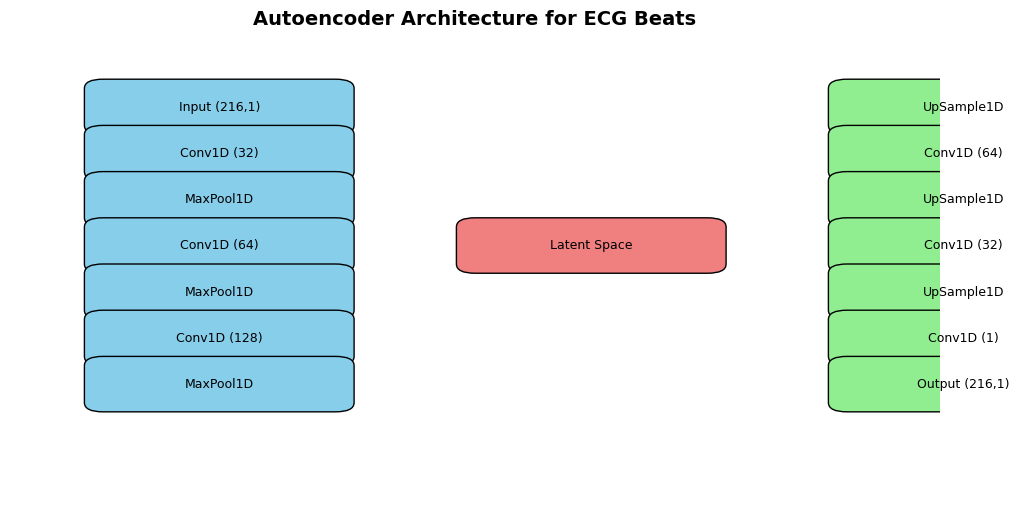

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Create figure
fig, ax = plt.subplots(figsize=(12,6))
ax.axis('off')

# Encoder blocks
encoder_layers = ["Input (216,1)", "Conv1D (32)", "MaxPool1D", "Conv1D (64)", "MaxPool1D", "Conv1D (128)", "MaxPool1D"]
decoder_layers = ["UpSample1D", "Conv1D (64)", "UpSample1D", "Conv1D (32)", "UpSample1D", "Conv1D (1)", "Output (216,1)"]

# Plot encoder
x, y = 0.1, 0.8
for i, layer in enumerate(encoder_layers):
    box = mpatches.FancyBboxPatch((x, y - i*0.1), 0.25, 0.08, boxstyle="round,pad=0.02", fc="skyblue", ec="black")
    ax.add_patch(box)
    ax.text(x+0.125, y - i*0.1 + 0.04, layer, ha="center", va="center", fontsize=9)

# Latent space
latent_x, latent_y = x+0.4, y - 0.3
box = mpatches.FancyBboxPatch((latent_x, latent_y), 0.25, 0.08, boxstyle="round,pad=0.02", fc="lightcoral", ec="black")
ax.add_patch(box)
ax.text(latent_x+0.125, latent_y+0.04, "Latent Space", ha="center", va="center", fontsize=9)

# Decoder
dec_x = latent_x + 0.4
for i, layer in enumerate(decoder_layers):
    box = mpatches.FancyBboxPatch((dec_x, latent_y - i*0.1 + 0.3), 0.25, 0.08, boxstyle="round,pad=0.02", fc="lightgreen", ec="black")
    ax.add_patch(box)
    ax.text(dec_x+0.125, latent_y - i*0.1 + 0.3 + 0.04, layer, ha="center", va="center", fontsize=9)

# Title
ax.set_title("Autoencoder Architecture for ECG Beats", fontsize=14, weight="bold")

plt.show()
